<a href="https://colab.research.google.com/github/zzaeyun/ESAA23_1/blob/main/%ED%95%B8%EC%A6%88%EC%98%A8_245to271.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



>  CHAPTER7 앙상블 학습과 랜덤 포레스트



**앙상블**

- 일련의 예측기로부터 예측을 수집하면 가장 좋은 모델 하나보다 더 좋은 예측을 얻을 수 있음
- 앙상블 학습/앙상블 방법
- ex) 훈련 세트로부터 무작위로 각기 다른 서브셋을 만들어 일련의 결정 트리 분류기를 훈련, 모든 개별 트리의 예측을 구하고 가장 많은 선택을 받은 클래스를 예측으로 삼음
  - 랜덤 포레스트: 결정 트리의 앙상블
  - 배깅, 부스팅, 스태킹

---

##**7.1 투표 기반 분류기**
1. 로지스틱 회귀 분류기, SVM 분류기, 랜덤 포레스트 분류기, K-최근접 이웃 분류기 등으로 훈련
2. 각 분류기의 예측을 모아서 가장 많이 선택된 클래스를 예측
  - 직접 투표(hard voting): 다수결 투표로 정해짐

<br>

- 앙상블에 포함된 개별 분류기 중 가장 뛰어난 것보다 정확도가 높을 경우가 많음
- 각 분류기가 약한 학습기(weak learner)일지라도 많고 다양하다면 앙상블은 강한 학습기(strong learner)가 될 수 있음
  - **큰 수의 법칙**: 실험 횟수가 증가하면 점점 정확도가 증가
  - 51% 정확도를 가진 1,000개의 분류기로 앙상블 모델을 구축하면 75%의 정확도를 기대할 수 있음
  - 하지만 모든 분류기가 완벽하게 독립적이고 오차에 상관관계가 없어야 가능
    - 분류기가 가능한 한 서로 독립적일 때 최고의 성능 발휘
    

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf=LogisticRegression()
rnd_clf=RandomForestClassifier()
svm_clf=SVC()

voting_clf=VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard'
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [18]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
  clf.fit(X_train, y_train)
  y_pred=clf.predict(X_test)
  print(clf.__class__.__name__,accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.888
SVC 0.896
VotingClassifier 0.912


- 투표 기반 분류기가 다른 개별 분류기보다 성능이 조금 더 높음

<br>

*간접 투표(soft voting): predict_proba() 메서드로 분류기가 클래스의 확률을 예측할 수 있으면 예측을 평균내어 확률이 가장 높은 클래스를 예측
  - 확률이 높은 투표에 비중을 더 두기 때문에 직접 투표 방식보다 성능이 높음
  - voting='soft'
    - SVC는 기본값에서는 클래스 확률을 제공하지 않으므로 probability 매개변수를 True로 지정



---

## **7.2 배깅과 페이스팅**

- 같은 알고리즘을 사용하고 훈련 세트의 서브셋을 무지가위로 구성하여 분류기를 각기 다르게 학습
- **배깅(bagging, booststrap aggregation)**: 훈련 세트에서 중복을 허용하여 샘플링
- **페이스팅(pasting)**

  - 같은 훈련 샘플을 여러 개의 예측기에 걸쳐 사용
  - 하지만 배깅만이 한 예측기를 위해 같은 훈련 샘플을 여러번 샘플링할 수 있음

<br>

- 모든 예측기가 훈련을 마치면 앙상블은 모든 예측기의 예측을 모아서 새로운 샘플에 대한 예측을 만듬
- 분류일 때는 수집함수로 통계적 최빈값(가장 많은 예측 결과)이고 회귀에서는 평균을 꼐산
- 개별 예측기는 원본 훈련 세트로 훈련시킨 것보다 훨씬 크게 편향되어 있어 수집 함수를 통과하면 편향과 분산이 모두 감소
  - *앙상블의 결과는 원본 데이터셋으로 하나의 예측기를 훈련시킬때와 비교해 편향은 비슷하지만 분산은 줄어든다.
  


###**7.2.1 사이킷런의 배깅과 페이스팅**
- 사이킷런의 BaaingClassifier, BaggingRegressor

<br>

- 결정 트리 분류기 500개의 앙상블을 훈련
- 각 분류기는 훈련 세트에서 중복을 허용하여 무작위로 선택된 100개의 샘플로 훈련
  - 페이스팅을 사용하려면 (boostrap=False)
  - n_jobs 매개변수는 사이킷런이 훈련과 예측에 사용할 CPU 코어 수를 지정 (-1로 지정하면 가용한 모든 코어 사용)

In [19]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf=BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1
)
bag_clf.fit(X_train, y_train)
y_pred=bag_clf.predict(X_test)

- BaggingClassifier는 기반이 되는 분류기가 결정 트리 분류기처럼 클래스 확률을 추정할 수 있으면(predict_proba() 함수가 있으면) 직접 투표 대신 자동으로 간접 투표 방식 사용


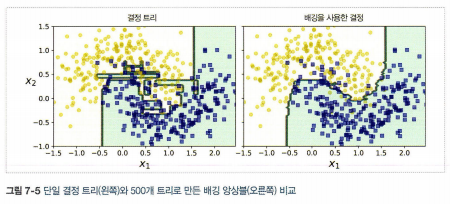

- 앙상블의 예측이 결정 트리 하나의 예측보다 일반화가 훨씬 잘 됨
- 앙상블은 비슷한 편향에서 더 작은 분산을 만듬

<br>

- 부트스트래핑은 각 예측기가 학습하는 서브셋에 다양성을 증가시키므로 배깅이 페이스팅보다 편향이 조금 더 높음
- 하지만 다양성을 추가한다는 것은 예측기들의 상관관계를 줄이므로 앙상블의 분산을 감소
  - 배깅과 페이스팅을 모두 평가해서 더 나은 쪽을 선택하는 것이 좋음

###**7.2.2 oob 평가**

- 배깅을 사용하면 중복을 허용하므로 한 예측기를 위해 여러 번 샘플링되거나 아예 선택되지 않을 수 있음
- BaggingClassifier는 기본값으로 중복을 허용하여 훈련 세트의 크기만큼인 m개의 샘플을 선택
  - 이는 평균적으로 63% 정도만 샘플링된다는 것을 의미
  - **oob(out-of-bag)**: 선택되지 않은 훈련 샘플
    - why 63%? m이 커지면 1-exp(-1)에 가까워지게 됨

<br>

- 예측기가 훈련되는 동안 oob 샘플은 사용하지 않으므로 별도의 검증 세트를 사용하지 않고 oob 샘플을 사용해 평가할 수 있음
- oob_score=True

In [20]:
bag_clf=BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True
)

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.896

- oob_decision_function_ 변수에서 oob 샘플에 대한 결정 함수의 값 확인 가능


In [21]:
from sklearn.metrics import accuracy_score
y_pred=bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.904

In [22]:
bag_clf.oob_decision_function_

array([[0.37777778, 0.62222222],
       [0.32160804, 0.67839196],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.07772021, 0.92227979],
       [0.43428571, 0.56571429],
       [0.01595745, 0.98404255],
       [1.        , 0.        ],
       [0.96825397, 0.03174603],
       [0.82941176, 0.17058824],
       [0.01169591, 0.98830409],
       [0.70680628, 0.29319372],
       [0.83435583, 0.16564417],
       [0.96428571, 0.03571429],
       [0.03333333, 0.96666667],
       [0.        , 1.        ],
       [0.97948718, 0.02051282],
       [0.97222222, 0.02777778],
       [1.        , 0.        ],
       [0.01724138, 0.98275862],
       [0.37912088, 0.62087912],
       [0.94680851, 0.05319149],
       [1.        , 0.        ],
       [0.98907104, 0.01092896],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.61081081, 0.38918919],
       [0.

##**7.3 랜덤 패치와 랜덤 서브스페이스**

BaggingClassifier는 특성 샘플링도 지원
- 샘플링은 max_features, bootstrap_features 두 매개 변수로 조절
  - 특성에 대한 샘플링으로 예측기는 무작위로 선택한 입력 특성의 일부분으로 훈련

- 이 기법은 이미지와 같은 매우 고차원의 데이터셋을 다룰 때 유용
- 훈련 특성과 샘플을 모두 샘플링하는 것을 랜덤 패치 방식이라고 함
  - **랜덤 서브스페이스 방식**: 훈련 샘플을 모두 사용하고 (bootstrap=False, max_samples=1.0) 특성은 샘플링하는 (bootstrap_features=True, max_features는 1.0보다 작게 설정)
  - 특성 샘플링은 더 다양한 예측기를 만들며 편향을 늘리는 대신 분산을 낮춤

##**7.4 랜덤 포레스트**

**랜덤 포레스트**
- 배깅 방법(또는 페이스팅)을 적용한 결정 트리의 앙상블
- 전형적으로 max_samples를 훈련 세트의 크기로 지정
- BaggingClassifier에 결정트리에 최적화되어 사용하기 편리한 RandomForestClassifier를 사용할 수 있음

<br>

- 500개 트리로 이루어진 랜덤 포레스트 분류기를 여러 CPU코어에서 훈련시키는 코드

In [23]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf=RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf=rnd_clf.predict(X_test)

- 랜덤 포레스트 알고리즘은 트리의 노드를 분할할 때 전체 특성 중에서 최선의 특성을 찾는 대신 무작위 선택한 특성 후보 중에서 최적의 특성을 찾는 식으로 무직위성을 더 주입
- 결국 트리를 더욱 다양하게 만들고 편향을 손해보는 대신 분산을 낮추어 전체적으로 더 훌륭한 모델을 만들어냄

In [24]:
bag_clf=BaggingClassifier(
    DecisionTreeClassifier(max_features='auto', max_leaf_nodes=16),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1
)

###**7.4.1 엑스트라 트리**

**익스트림 랜덤 트리 앙상블 (엑스트라 트리)**
- 랜덤 포레스트에서 트리를 만들 때 각 노드는 무작위로 특성의 서브셋을 만들어 분할에 사용. 
- 트리를 더욱 무작위하게 만들기 위해 후보 특성을 사용해 무작위로 분할한 다음 그중에서 최상의 분할을 선택
- 편향이 늘어나지만 분산을 낮추게 됨
- 최적의 임곗값을 찾는 것이 트리 알고리즘에서 가장 시간이 많이 소요되는 작업 중 하나이므로 훨씬 빠름



- 사이킷런의 ExtraTreeClassifier 사용

<br>

###**7.4.2 특성 중요도**
- 랜덤 포레스트는 특성의 상대적 중요도를 측정하기 쉽다는 장점이 있음
- 사이킷런은 어떤 특성을 사용한 노드가 평균적으로 불순도를 얼마나 감소시키는지 확인하여 특성의 중요도를 측정
  - 가중치 평균이며 각 노드의 가중치는 연관된 훈련 샘플 수와 같음
- 사이킷런은 훈련 끝난 뒤 특성마다 자동으로 이 점수를 계산하고 중요도의 전체 합이 1이 되도록 결괏값을 정규화
- feature_importances_ 변수에 저장

<br>
- iris 데이터셋에 RandomForestClassifier를 훈련시키고 각 특성의 중요도를 출력

In [25]:
from sklearn.datasets import load_iris
iris=load_iris()
rnd_clf=RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris['data'], iris['target'])
for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
  print(name, score)

sepal length (cm) 0.0977569844828831
sepal width (cm) 0.026051946099157102
petal length (cm) 0.4420226331694348
petal width (cm) 0.4341684362485251


##**7.5 부스팅**

**부스팅**
- 약한 학습기를 여러 개 연결하여 강한 학습기를 만드는 앙상블 기법
  - 에이다부스트(AdaBoost, adaptive boosting의 줄임말)
  - 그레이디언트 부스팅(gradient boosting)

###**7.5.1 에이다부스트**

- 이전 예측기를 보완하는 새로운 예측기를 만드는 방법은 이전 모델이 과소적합했던 훈련 샘플의 가중치를 더 높이는 것
- 새로운 예측기는 학습하기 어려운 샘플에 점점 맞춰지게 됨

<br>

1. 첫 번째 분류기를 훈련 세트에 훈련시키고 에측
2. 그다음에 알고리즘이 잘못 분류된 훈련 샘플의 가중치를 상대적으로 높임
3. 두 번재 분류기는 업데이트된 가중치를 사용해 훈련 세트에서 훈련하고 다시 예측
4. 다시 가중치를 업데이트

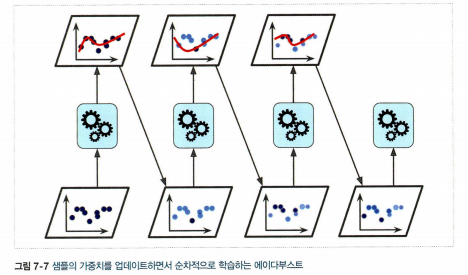

- 연속된 학습 기법은 경사 하강법가 비슷
  - 경사 하강법은 비용 함수를 최소화하기 위해 한 예측기의 모델 파라미터를 조정
  - 에이다 부스트는 점차 더 좋아지도록 앙상블에 예측기를 추가

### **7.5.2 그레이디언트 부스팅**

**그레이디언트 부스팅**
- 이전 예측기가 만든 **잔여 오차**에 새로운 예측기를 학습


In [26]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1=DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2)

In [27]:
y2=y-tree_reg1.predict(X)
tree_reg2= DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X,y2)

DecisionTreeRegressor(max_depth=2)

In [28]:
y3=y2-tree_reg2. predict(X)
tree_reg3=DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X,y3)

DecisionTreeRegressor(max_depth=2)

In [30]:
#y_pred=sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

- 사이킷런의 GradientBosstingRegressor
  - n_estimators: 트리 수 
  - max_depth
  - min_samples_leaf

In [33]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt=GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X,y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)

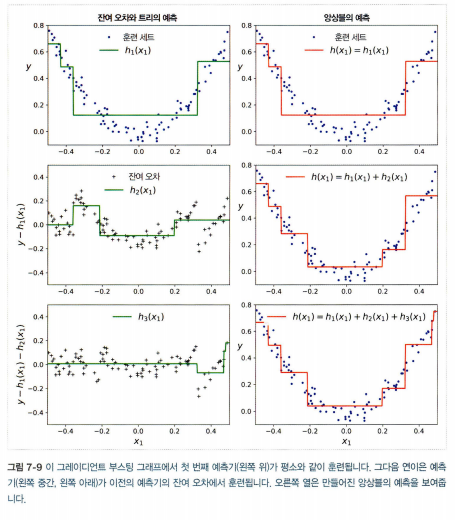

- learning_rate 매개변수가 각 트리의 기여 정도를 조절
  - 축소: 0.1처럼 낮게 설정하면 앙상블을 훈련 세트에 학습시키기 위해 많은 트리가 필요하지만 예측 성능은 좋아짐

<br>

- 최적의 트리 수를 찾기 위해서는 조기 종료 기법을 사용
  - staged_predict() 메서드 사용

In [36]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val=train_test_split(X,y)

gbrt=GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)

errors=[mean_squared_error(y_val, y_pred)
        for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators=np.argmin(errors) + 1

gbrt_best= GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators)
gbrt_best.fit(X_train,y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=114)

warm_start=True로 설정하면 fit( ) 메서드가 호출될 때 기존 트리를 유지하고 훈련을 추가할 수 있도록 해줌

In [37]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # 조기 종료

**확률적 그레이디언트 부스팅**
- subsample: 각 트리가 훈련할 때 사용할 훈련 샘플의 비율을 지정
  - subsample=0.25: 각 트리는 무작위로 선택된 25%의 훈련 샘플로 학습
  - 편향이 높아지는 대신 분산이 낮아지게 됨

- XGBoost 파이썬 라이브러리

In [38]:
import xgboost

xgb_reg=xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred=xgb_reg.predict(X_val)

In [41]:
xgb_reg.fit(X_train, y_train,
            eval_set=[(X_val, y_val)], early_stopping_rounds=2)
y_pred=xgb_reg.predict(X_val)

[0]	validation_0-rmse:0.39171
[1]	validation_0-rmse:0.32493
[2]	validation_0-rmse:0.28392
[3]	validation_0-rmse:0.26228
[4]	validation_0-rmse:0.25123
[5]	validation_0-rmse:0.24625
[6]	validation_0-rmse:0.24181
[7]	validation_0-rmse:0.23521
[8]	validation_0-rmse:0.23380
[9]	validation_0-rmse:0.23314
[10]	validation_0-rmse:0.23327


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


##**7.6 스태킹**

**스태킹(stacking, stacked generalizaion)**
- 모든 예측기의 예측값을 가지고 마지막 예측기(블렌더 또는 메타 학습기)가 이 예측을 입력으로 받아 최종 예측
- 사이킷럼은 스태킹을 직접 지원하지 않음